Copyright 2021-2024 @ Shenzhen Bay Laboratory & Peking University & Huawei Technologies Co., Ltd

This code is a part of MindSPONGE:
MindSpore Simulation Package tOwards Next Generation molecular modelling.

MindSPONGE is open-source software based on the AI-framework:
MindSpore (https://www.mindspore.cn/)

Licensed under the Apache License, Version 2.0 (the "License");
you may not use this file except in compliance with the License.

You may obtain a copy of the License at http://www.apache.org/licenses/LICENSE-2.0

Unless required by applicable law or agreed to in writing, software
distributed under the License is distributed on an "AS IS" BASIS,
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.

See the License for the specific language governing permissions and
limitations under the License.

Load and evaluate forcefield model.

配置环境, 导入必要的包, 设置需要evaluate的网络

In [2]:
import numpy as np
import matplotlib.pyplot as plt

import sys
import os
os.environ['MINDSPONGE_HOME']='/home/mindspore/work/summerschool/mindscience/MindSPONGE/src'
os.environ['GLOG_v']=str(4)
path = os.getenv('MINDSPONGE_HOME')
if path:
    sys.path.insert(0, path)
sys.path.append('../..')
data_dir = './data'

test_dataset = data_dir + "/dataset/data_origin_testset_1024.npz"
testing = "trained" # "trained" or others
if testing == "trained":
    ckpt = data_dir + "/ckpt/cybertron-molct-trained-best.ckpt"
    yaml = data_dir + "/conf/configure_MolCT_trained.yaml"
else:
    ckpt = data_dir + "/ckpt/cybertron-molct-best.ckpt"
    yaml = data_dir + "/conf/configure_MolCT.yaml"

import mindspore as ms
from mindspore import Tensor
from cybertron.model import MolCT
from cybertron.readout import AtomwiseReadout
from cybertron.cybertron import Cybertron
from sponge.data import read_yaml
from mindspore import load_checkpoint
from mindspore import context
from mindspore.ops import grad

加载网络设置和参数

In [3]:
context.set_context(mode=context.GRAPH_MODE, device_target="Ascend")

config = read_yaml(yaml)
net = Cybertron(**config)
_ = load_checkpoint(ckpt, net)

加载数据, 求出网络预测值

In [4]:
test_dataset = np.load(test_dataset)
scales = test_dataset['scale']
shifts = test_dataset['shift']
net.set_scaleshift(scale=scales, shift=shifts) 
print(scales, shifts)

coordinate = test_dataset['coordinate']
coordinate = Tensor(coordinate,  dtype=ms.float32)
real_E = test_dataset['label']
pred_E = net(coordinate).asnumpy()
pred_E = pred_E.reshape(-1)
real_E = real_E.flatten()

[4.64063241] [-538.75739377]


绘制能量的真实值-预测值图像

/tmp/ipykernel_3879818/4057791457.py:10: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


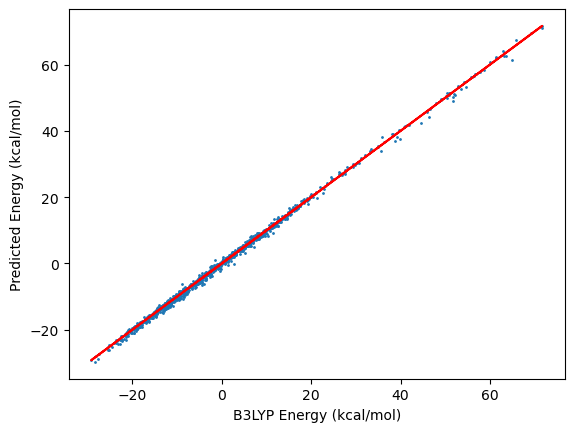

In [5]:
fig = plt.figure()
pred_shift = pred_E - np.mean(pred_E)
real_shift = real_E - np.mean(real_E)

ax = fig.add_subplot()
ax.scatter(real_shift / 4.184, pred_shift / 4.184 , s=1, label = 'predE')
ax.plot(real_shift / 4.184, real_shift / 4.184, color='red', label = 'realE')
ax.set_xlabel('B3LYP Energy (kcal/mol)')
ax.set_ylabel('Predicted Energy (kcal/mol)')
fig.show()

求出力预测值, 绘制力的真实值-预测值图像

/tmp/ipykernel_3879818/3153979486.py:16: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


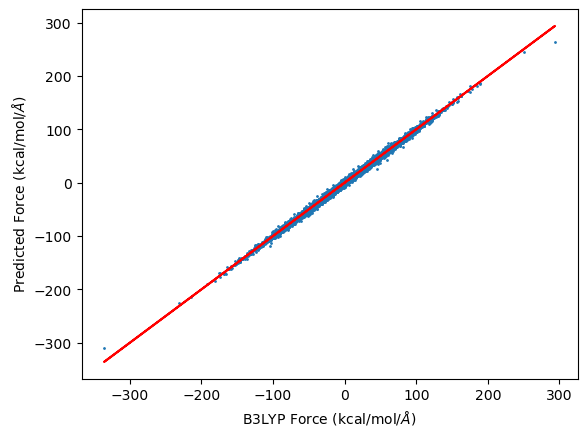

In [6]:
fig = plt.figure()

grad_fn = grad(net)
pred_F = -grad_fn(coordinate).asnumpy()

real_F = test_dataset['force']

take_real_F = real_F.reshape(-1)
take_pred_F = pred_F.reshape(-1)

ax = fig.add_subplot()
ax.scatter(take_real_F / 41.84, take_pred_F / 41.84, s=1, label='predF')
ax.plot(take_real_F / 41.84, take_real_F / 41.84, color='red', label='realF')
ax.set_xlabel('B3LYP Force (kcal/mol/$\AA$)')
ax.set_ylabel('Predicted Force (kcal/mol/$\AA$)')
fig.show()

打印网络能量的平均绝对误差Mean Absolute Error (MAE) 和力的均方根误差Root Mean Square Error (RMSE)

In [9]:
print(f"Energy MAE: {np.mean(np.abs(pred_shift - real_shift))/4.184} kcal/mol")
print(f"Force RMSE: {np.mean(np.linalg.norm(pred_F - real_F,axis=-1))/41.84} kcal/mol/A")

Energy MAE: 0.5453524124553965 kcal/mol
Force RMSE: 2.2129733521441426 kcal/mol/A
